<a href="https://colab.research.google.com/github/FrumsM/Car-price-prediction/blob/main/House_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание проекта

Проект основан на участии в сорвеновании Kaggle: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

Цель проекта - предсказать стоимость жилых домов в городе Эймс штат Айова, используя продвинутые модели градиентного бустинга:

*   Catboost;
*   XGBoost;
*   LightGBM.

Описание датасетов:

df_train - тренировочный датасет;

df_test - тестовый датасет;

submission - образец файла отправки в правильном формате.

Метрика: RMSE

# Загрузка библиотек

In [ ]:
!pip install catboost
!pip install optuna
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from matplotlib.gridspec import GridSpec
from scipy.stats import skew, norm
from google.colab import *

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import optuna
import shap
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

# Загрузка датасетов

In [ ]:
drive.mount('/content/drive')
path1 = '/content/drive/My Drive/Datasets/house_test.csv'
path2 = '/content/drive/My Drive/Datasets/house_train.csv'
path3 = '/content/drive/My Drive/Datasets/house_submission.csv'
df_test = pd.read_csv(path1)
df_train = pd.read_csv(path2)
submission = pd.read_csv(path3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.concat([df_train, df_test])

In [ ]:
df.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
718,719,60,RL,96.00,10542,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,341000.00
613,614,20,RL,70.00,8402,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2007,New,Partial,147000.00
99,100,20,RL,77.00,9320,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,400,1,2010,WD,Normal,128950.00
191,1652,160,RM,21.00,1680,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,NaN
151,152,20,RL,107.00,13891,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,New,Partial,372402.00


In [ ]:
submission['SalePrice'] = 0
submission.sample(5)

,Id,SalePrice
1227,2688,0
1310,2771,0
411,1872,0
39,1500,0
368,1829,0


# Анализ датасета

In [ ]:
df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.00
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.00
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.00
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.00
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.00


Кол-во строк и столбцов:

In [ ]:
df.shape

(2919, 81)

Информация о колонках датасета:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

**Всю информацию о датасете можно посмотреть по ссылке:** https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

Процентный список пропущенных данных:

In [ ]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Id - 0%
MSSubClass - 0%
MSZoning - 0%
LotFrontage - 17%
LotArea - 0%
Street - 0%
Alley - 93%
LotShape - 0%
LandContour - 0%
Utilities - 0%
LotConfig - 0%
LandSlope - 0%
Neighborhood - 0%
Condition1 - 0%
Condition2 - 0%
BldgType - 0%
HouseStyle - 0%
OverallQual - 0%
OverallCond - 0%
YearBuilt - 0%
YearRemodAdd - 0%
RoofStyle - 0%
RoofMatl - 0%
Exterior1st - 0%
Exterior2nd - 0%
MasVnrType - 1%
MasVnrArea - 1%
ExterQual - 0%
ExterCond - 0%
Foundation - 0%
BsmtQual - 3%
BsmtCond - 3%
BsmtExposure - 3%
BsmtFinType1 - 3%
BsmtFinSF1 - 0%
BsmtFinType2 - 3%
BsmtFinSF2 - 0%
BsmtUnfSF - 0%
TotalBsmtSF - 0%
Heating - 0%
HeatingQC - 0%
CentralAir - 0%
Electrical - 0%
1stFlrSF - 0%
2ndFlrSF - 0%
LowQualFinSF - 0%
GrLivArea - 0%
BsmtFullBath - 0%
BsmtHalfBath - 0%
FullBath - 0%
HalfBath - 0%
BedroomAbvGr - 0%
KitchenAbvGr - 0%
KitchenQual - 0%
TotRmsAbvGrd - 0%
Functional - 0%
Fireplaces - 0%
FireplaceQu - 49%
GarageType - 5%
GarageYrBlt - 5%
GarageFinish - 5%
GarageCars - 0%
GarageArea - 0%
GarageQu

Сколько всего значений в каждом столбце пропущено:

In [ ]:
df.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
                 ... 
MoSold              0
YrSold              0
SaleType            1
SaleCondition       0
SalePrice        1459
Length: 81, dtype: int64

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

Описание числовых признаков:

In [ ]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.00,2919.00,2433.00,2919.00,2919.00,2919.00,2919.00,2919.00,2896.00,2918.00,...,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,2919.00,1460.00
mean,1460.00,57.14,69.31,10168.11,6.09,5.56,1971.31,1984.26,102.20,441.42,...,93.71,47.49,23.10,2.60,16.06,2.25,50.83,6.21,2007.79,180921.20
std,842.79,42.52,23.34,7887.00,1.41,1.11,30.29,20.89,179.33,455.61,...,126.53,67.58,64.24,25.19,56.18,35.66,567.40,2.71,1.31,79442.50
min,1.00,20.00,21.00,1300.00,1.00,1.00,1872.00,1950.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2006.00,34900.00
25%,730.50,20.00,59.00,7478.00,5.00,5.00,1953.50,1965.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,2007.00,129975.00
50%,1460.00,50.00,68.00,9453.00,6.00,5.00,1973.00,1993.00,0.00,368.50,...,0.00,26.00,0.00,0.00,0.00,0.00,0.00,6.00,2008.00,163000.00
75%,2189.50,70.00,80.00,11570.00,7.00,6.00,2001.00,2004.00,164.00,733.00,...,168.00,70.00,0.00,0.00,0.00,0.00,0.00,8.00,2009.00,214000.00
max,2919.00,190.00,313.00,215245.00,10.00,9.00,2010.00,2010.00,1600.00,5644.00,...,1424.00,742.00,1012.00,508.00,576.00,800.00,17000.00,12.00,2010.00,755000.00


Описание нечисловых признаков:

In [ ]:
df.describe(include='O')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,2915,2919,198,2919,2919,2917,2919,2919,2919,2919,...,2762,2760,2760,2760,2919,10,571,105,2918,2919
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,2265,2907,120,1859,2622,2916,2133,2778,443,2511,...,1723,1230,2604,2654,2641,4,329,95,2525,2402


Кол-во уникальных значений в каждой колонке:

In [ ]:
df.nunique()

Id               2919
MSSubClass         16
MSZoning            5
LotFrontage       128
LotArea          1951
                 ... 
MoSold             12
YrSold              5
SaleType            9
SaleCondition       6
SalePrice         663
Length: 81, dtype: int64

Тепловая карта корреляций:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

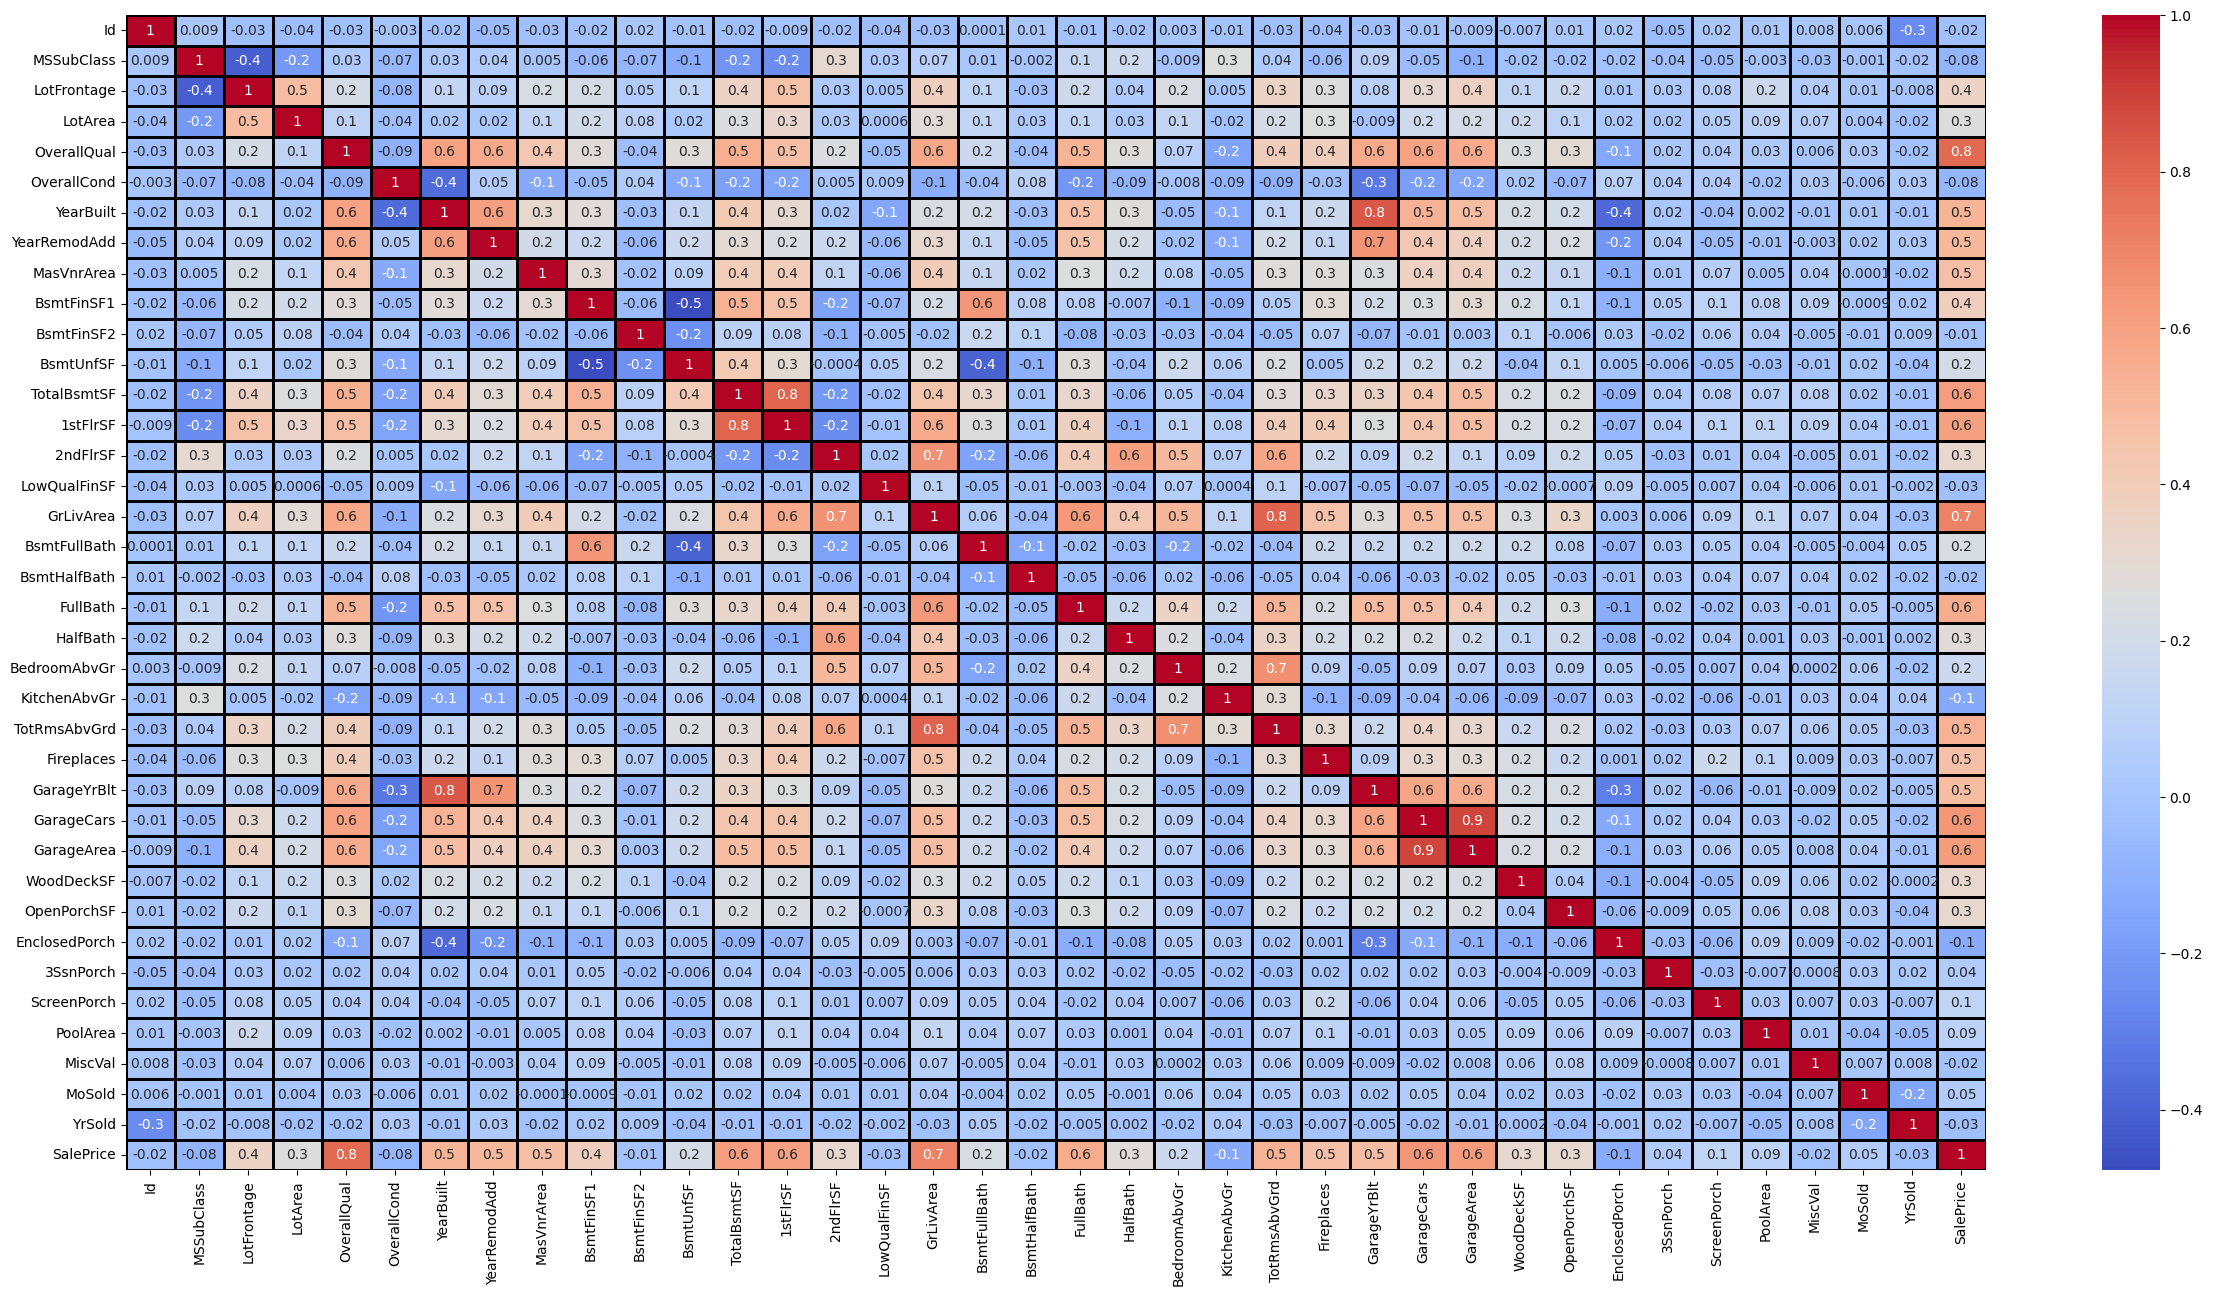

In [ ]:
fig, ax = plt.subplots(figsize=(30, 15))
sns.heatmap(df.corr(), annot=True, fmt='.1g', cmap= 'coolwarm', linewidths=2, linecolor='black')

# EDA

Распределение цен жилых домов:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


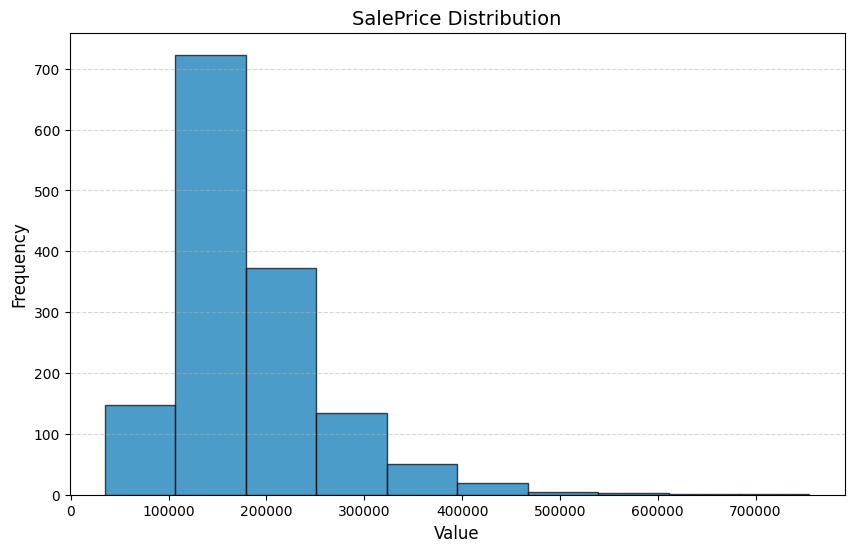

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-colorblind')

plt.figure(figsize=(10, 6))

plt.hist(df['SalePrice'], bins=10, edgecolor='black', alpha=0.7)

plt.title('SalePrice Distribution', fontsize=14)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


**Цены жилых домов подчиняются закону нормального распределения**

Распределение цен продажи по условиям продажи:

Mean of empty slice


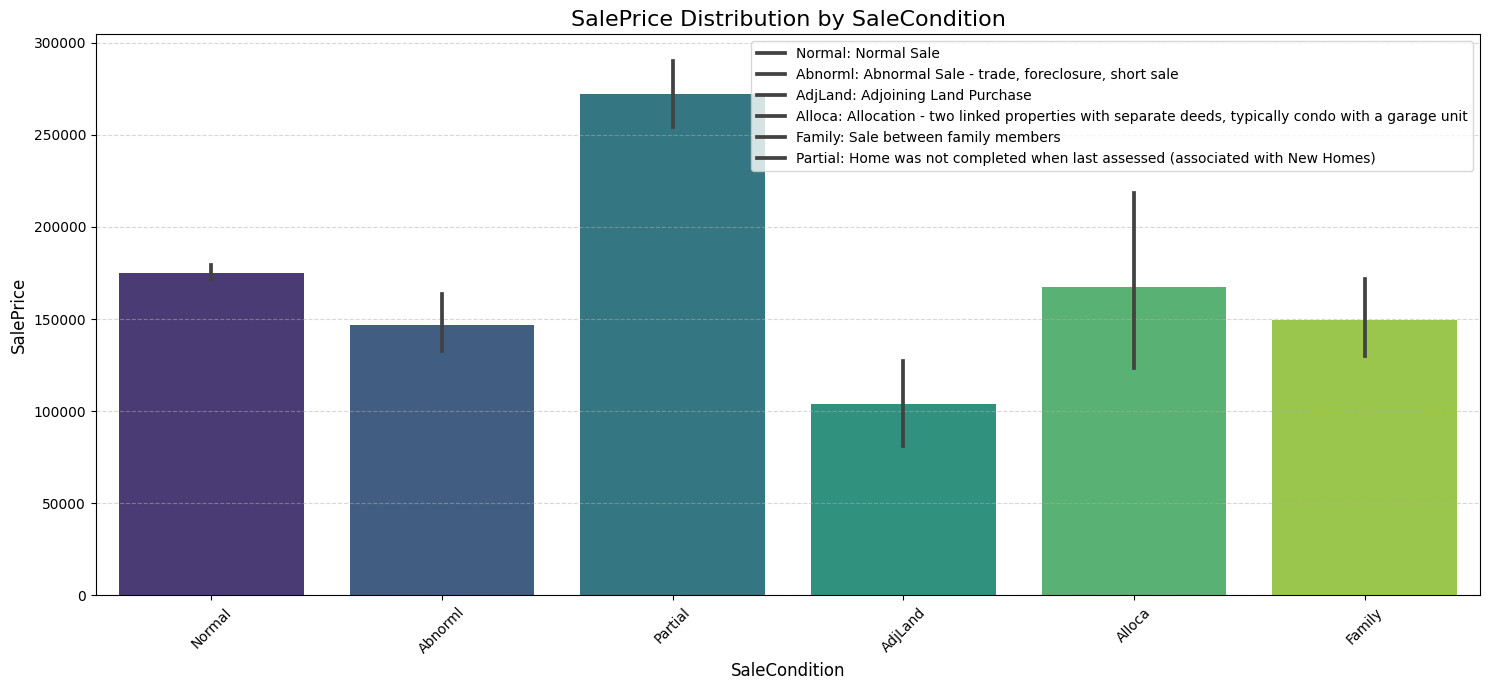

In [ ]:
legend_dict = {'Normal': 'Normal Sale',
'Abnorml': 'Abnormal Sale - trade, foreclosure, short sale',
'AdjLand': 'Adjoining Land Purchase',
'Alloca': 'Allocation - two linked properties with separate deeds, typically condo with a garage unit',
'Family': 'Sale between family members',
'Partial': 'Home was not completed when last assessed (associated with New Homes)'}

plt.figure(figsize=(15, 7))
sns.barplot(data=df, x='SaleCondition', y='SalePrice', palette='viridis')
plt.title('SalePrice Distribution by SaleCondition', fontsize=16)
plt.xlabel('SaleCondition', fontsize=12)
plt.ylabel('SalePrice', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

legend_labels = [f'{key}: {legend_dict[key]}' for key in legend_dict]
plt.legend(legend_labels, loc='upper right', fontsize=10)

plt.show()

**Больше всего в среднем стоят строящиеся дома. Последняя оценка стоимости дома была совершена до его постройки. Можно предположить, что покупатели переплачивали за дом, так как оценки были завышены. Остальные условия продажи примерно равны (не считая примыкающих участков)**

Распределение цен продаж по месяцам:

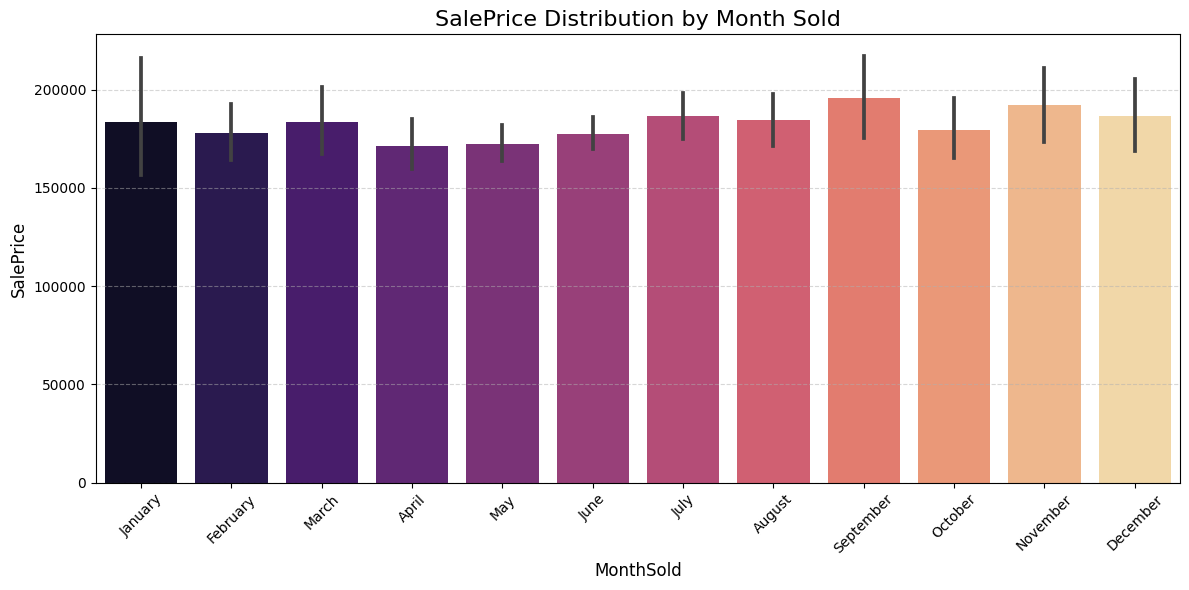

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='MoSold', y='SalePrice', palette='magma')
plt.title('SalePrice Distribution by Month Sold', fontsize=16)
plt.xlabel('MonthSold', fontsize=12)
plt.ylabel('SalePrice', fontsize=12)
plt.xticks(ticks=range(12), labels=[calendar.month_name[i] for i in range(1, 13)], rotation=45)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

**Особой разницы распределения цен продаж по месяцам не найдено**

Распределение цен продажи по годам:

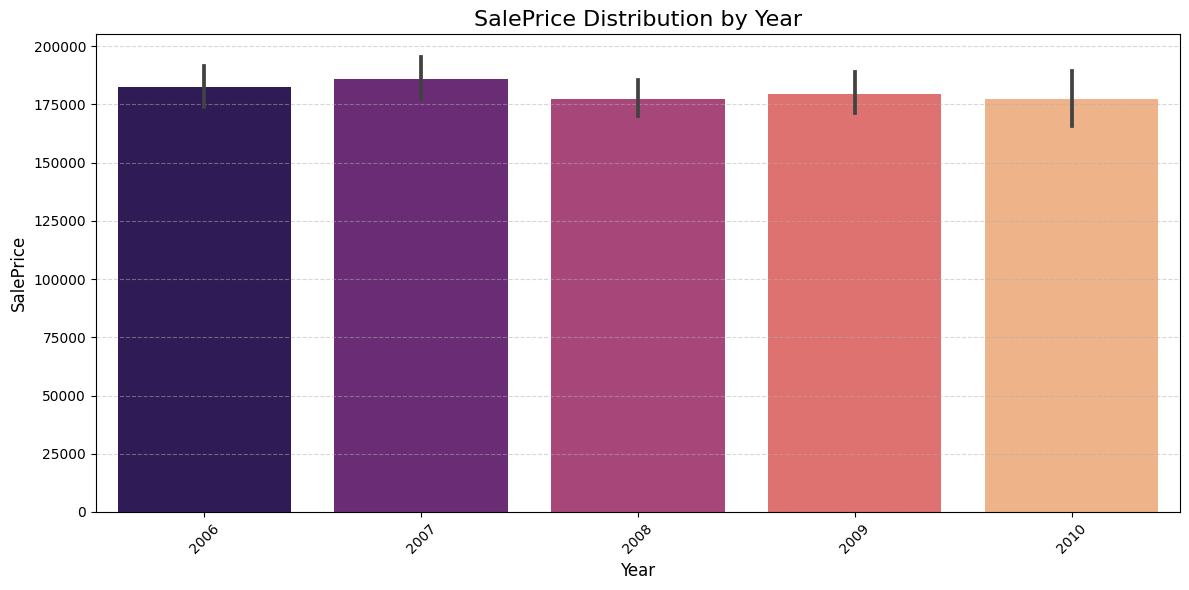

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='YrSold', y='SalePrice', palette='magma')
plt.title('SalePrice Distribution by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('SalePrice', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

**Особой разницы распределения цен продаж по годам не найдено**

# Предобработка датасета

Пропущенные значения в смешанных типах данных:

In [ ]:
df.select_dtypes(object).isnull().sum()

MSZoning            4
Street              0
Alley            2721
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinType2       80
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         1
Functional          2
FireplaceQu      1420
GarageType        157
GarageFinish      159
GarageQual        159
GarageCond        159
PavedDrive          0
PoolQC           2909
Fence            2348
MiscFeature      2814
SaleType            1
SaleCondition       0
dtype: int64

Процентный список пропущенных значений в смешанных типах данных:

In [ ]:
for col in df.select_dtypes(object).columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

MSZoning - 0%
Street - 0%
Alley - 93%
LotShape - 0%
LandContour - 0%
Utilities - 0%
LotConfig - 0%
LandSlope - 0%
Neighborhood - 0%
Condition1 - 0%
Condition2 - 0%
BldgType - 0%
HouseStyle - 0%
RoofStyle - 0%
RoofMatl - 0%
Exterior1st - 0%
Exterior2nd - 0%
MasVnrType - 1%
ExterQual - 0%
ExterCond - 0%
Foundation - 0%
BsmtQual - 3%
BsmtCond - 3%
BsmtExposure - 3%
BsmtFinType1 - 3%
BsmtFinType2 - 3%
Heating - 0%
HeatingQC - 0%
CentralAir - 0%
Electrical - 0%
KitchenQual - 0%
Functional - 0%
FireplaceQu - 49%
GarageType - 5%
GarageFinish - 5%
GarageQual - 5%
GarageCond - 5%
PavedDrive - 0%
PoolQC - 100%
Fence - 80%
MiscFeature - 96%
SaleType - 0%
SaleCondition - 0%


**В некоторых столбцах пропущено огромное кол-во значений. Это обусловлено тем, что некоторые привилегии отсутствуют во многих жилых домах**

Замена пропущенных значений в столбцах с более 40% NaN:

In [ ]:
lst = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
for key in lst:
  df[key] = df[key].replace(np.nan,'Not Available')

In [ ]:
df.select_dtypes(object).isnull().sum()

MSZoning           4
Street             0
Alley              0
LotShape           0
LandContour        0
Utilities          2
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
RoofStyle          0
RoofMatl           0
Exterior1st        1
Exterior2nd        1
MasVnrType        24
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Heating            0
HeatingQC          0
CentralAir         0
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu        0
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
PavedDrive         0
PoolQC             0
Fence              0
MiscFeature        0
SaleType           1
SaleCondition      0
dtype: int64

**Оставшиееся пропущенных значения можно заменить наиболее часто встречаемыми значениями**

Замена пропущенных значений при помощи метода SimpleImputer библиотеки sklearn

In [ ]:
lst_imp = ['MSZoning','Utilities','Exterior1st','Exterior2nd','MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
           'BsmtFinType2','Electrical','KitchenQual','Functional','SaleType','GarageType','GarageQual','GarageCond','GarageFinish']
scaler_object = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
for key in lst_imp:
  df[key] = scaler_object.fit_transform(df[key].values.reshape(-1, 1))

Пропущенные значения в столбцах типа float:

In [ ]:
df.select_dtypes(float).isnull().sum()

LotFrontage      486
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
GarageYrBlt      159
GarageCars         1
GarageArea         1
SalePrice       1459
dtype: int64

Процентный список пропущенных значений в столбцах типа float:

In [ ]:
for col in df.select_dtypes(float).columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

LotFrontage - 17%
MasVnrArea - 1%
BsmtFinSF1 - 0%
BsmtFinSF2 - 0%
BsmtUnfSF - 0%
TotalBsmtSF - 0%
BsmtFullBath - 0%
BsmtHalfBath - 0%
GarageYrBlt - 5%
GarageCars - 0%
GarageArea - 0%
SalePrice - 50%


Распределения для столбцов с пропущенными значениями:

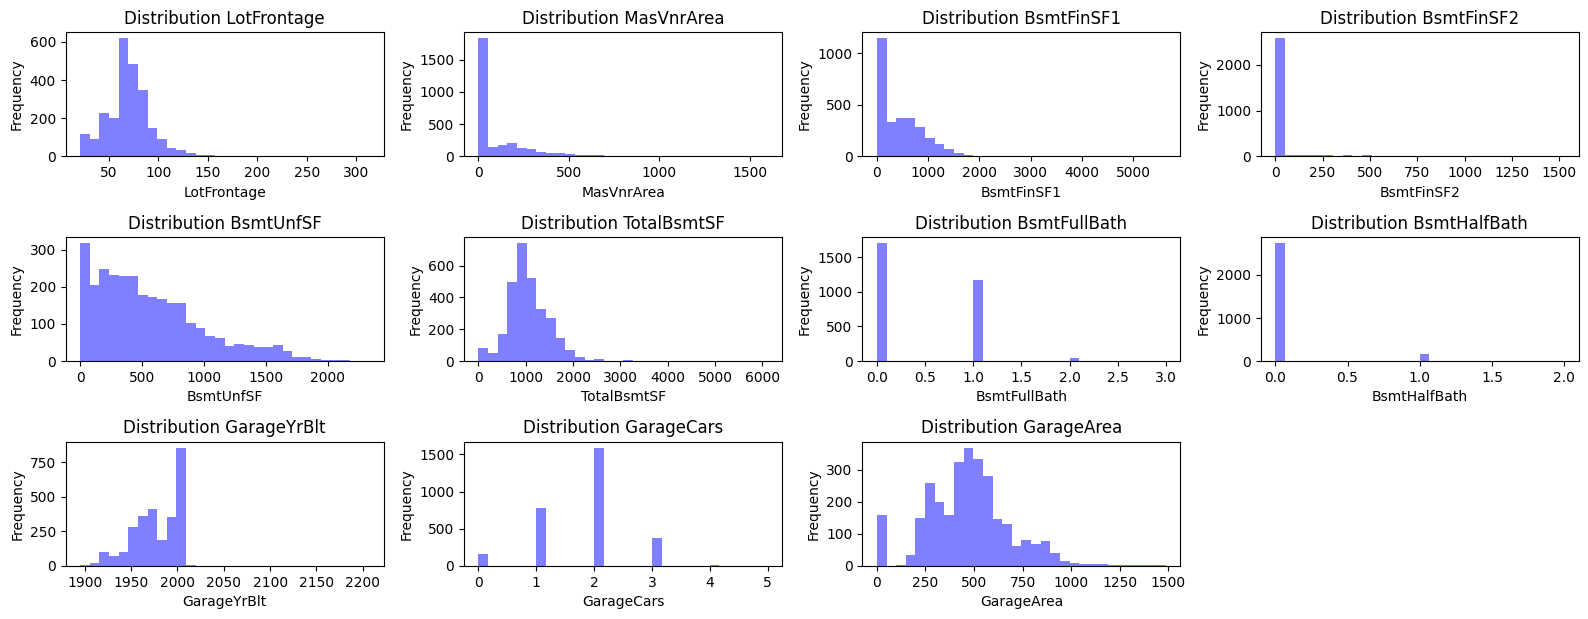

In [ ]:
lst_float = ['LotFrontage', 'MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','GarageYrBlt','GarageCars','GarageArea']

num_rows = 6
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))

for i, column in enumerate(lst_float):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    ax.hist(df[column], bins=30, color='blue', alpha=0.5)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution ' + column)


if len(lst_float) < num_rows * num_cols:
    for i in range(len(lst_float), num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

**Большая часть столбцов не имеет нормального распределения**

Ящики усов столбцов с пропущенными значениями

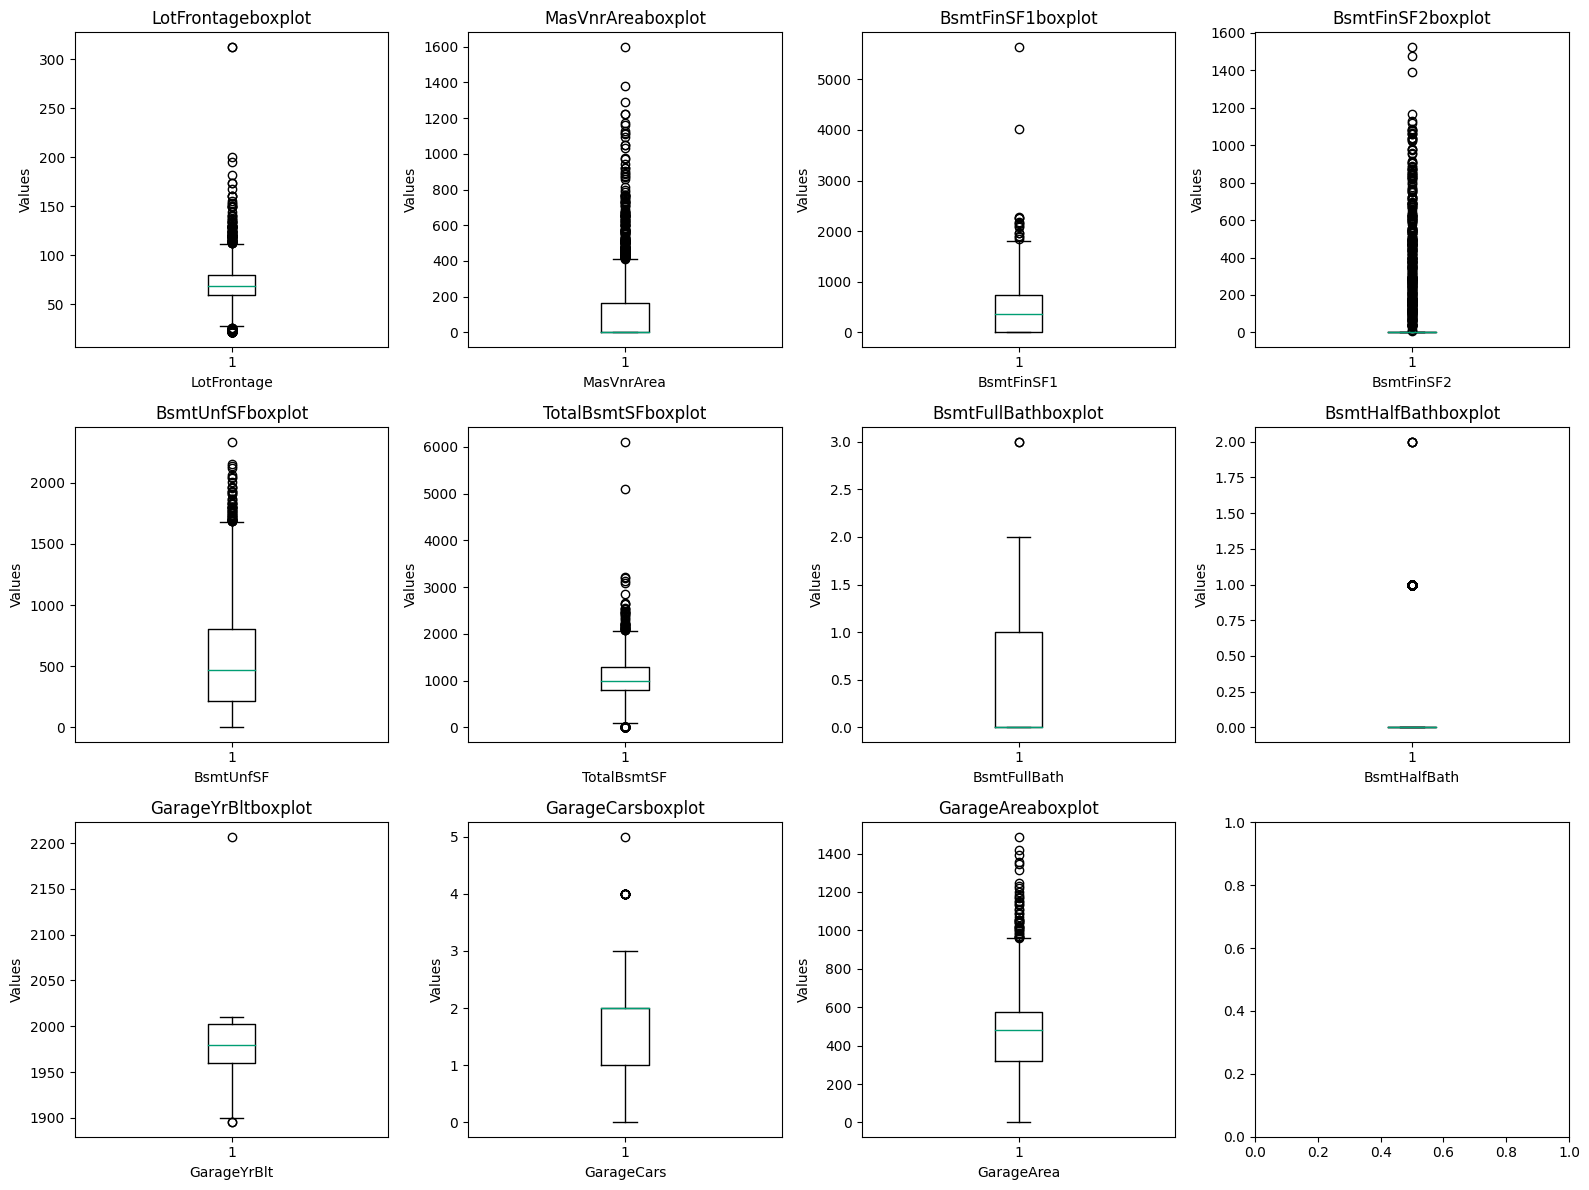

In [ ]:
num_rows = 3
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))


for i, column in enumerate(lst_float):
    row = i // num_cols
    col = i % num_cols

    if i < len(lst_float):
        ax = axes[row, col]
        ax.boxplot(df[column].dropna())
        ax.set_xlabel(column)
        ax.set_ylabel('Values')
        ax.set_title(column + "boxplot")
    else:
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

**Везде есть выбросы, поэтому следует заменить все пропущенные значения на медиану**

Замена пропущенных значений на медиану при промощи SimpleImputer

In [ ]:
scaler_float = SimpleImputer(missing_values=np.nan, strategy='median')
for key in lst_float:
  df[key] = scaler_float.fit_transform(df[key].values.reshape(-1, 1))

In [ ]:
df.select_dtypes(float).isnull().sum()

LotFrontage        0
MasVnrArea         0
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
BsmtFullBath       0
BsmtHalfBath       0
GarageYrBlt        0
GarageCars         0
GarageArea         0
SalePrice       1459
dtype: int64

Разделение датасета на фиктивные переменыые

In [ ]:
df = pd.get_dummies(df)
df.sample(5)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
816,817,20,68.00,11425,5,6,1954,1954,0.00,486.00,...,0,0,0,1,0,0,0,0,1,0
1309,2770,20,74.00,7400,7,6,1962,1962,0.00,809.00,...,0,0,0,1,0,0,0,0,1,0
449,450,50,50.00,6000,3,7,1948,2002,0.00,331.00,...,0,0,0,1,0,0,0,0,1,0
169,1630,120,28.00,7296,8,5,2004,2005,0.00,1965.00,...,0,0,0,1,0,0,0,0,1,0
330,331,90,68.00,10624,5,4,1964,1964,84.00,40.00,...,0,0,0,1,0,0,0,0,1,0


Избавление от перекосов

In [ ]:
numeric_features = df.dtypes[df.dtypes != object].index
skewed_features = df[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[skewed_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    df[i] = np.log1p(df[i])

# Feature Engineering

Признак со средней площади на одну комнату:

In [ ]:
df["SqFtPerRoom"] = df["GrLivArea"] / (df["TotRmsAbvGrd"] + df["FullBath"] + df["HalfBath"] + df["KitchenAbvGr"])

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


Признак возраста объекта на момент продажи:

In [ ]:
df["Age"] = df["YrSold"] - df["YearBuilt"]

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


Признак возраста с момента последнего ремонта на момент продажи объекта:

In [ ]:
df["Renovate"] = df["YearRemodAdd"] - df["YearBuilt"]

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


"Качественная" площадь объекта:

In [ ]:
df["HighQualSF"] = df["GrLivArea"] + df["1stFlrSF"] + df["2ndFlrSF"] + 0.5 * df["GarageArea"] + 0.5 * df["TotalBsmtSF"] + 1 * df["MasVnrArea"]

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


Общий рейтинг объекта:

In [ ]:
df['Total_Home_Quality'] = df['OverallQual'] + df['OverallCond']

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


Общее кол-во ванных комнат:

In [ ]:
df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [ ]:
df.sample(5)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SqFtPerRoom,Age,Renovate,HighQualSF,Total_Home_Quality,Total_Bathrooms
701,702,3.04,4.39,9.17,7,1.79,1969,1969,5.13,0.00,...,0.00,0.00,1,0.00,1.63,37,0,286.78,8.79,1.35
419,1880,3.04,4.34,8.85,5,2.08,1979,1979,3.71,6.57,...,0.00,0.00,1,0.00,1.96,30,0,242.76,7.08,1.69
1156,1157,4.39,4.45,9.14,5,2.20,1965,1999,0.00,6.45,...,0.00,0.00,1,0.00,1.54,43,34,268.84,7.20,2.35
633,634,3.04,4.39,9.13,5,2.08,1954,2005,0.00,6.18,...,0.00,0.00,1,0.00,1.91,53,51,147.41,7.08,1.35
1166,1167,3.04,4.17,9.26,8,1.79,2008,2008,4.29,0.00,...,0.00,0.00,1,0.00,1.56,2,0,410.88,9.79,2.00


In [ ]:
df_train = df[df['SalePrice'].notna()]
df_test = df[df['SalePrice'].isna()]

In [ ]:
df_train['Id'] = 0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# ML

Разделение данных:

In [ ]:
X = df_train.drop(columns = ['SalePrice'],axis = 1)
y = df_train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42, test_size = 0.25)

Обучение моделей градиентного бустинга с использованием optuna для подбора параметров:

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 300, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 3, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 10, log=True),
        'random_seed': 42
    }

    catboost_model = cb.CatBoostRegressor(**params)
    xgboost_model = xgb.XGBRegressor(**params)
    lightgbm_model = lgb.LGBMRegressor(**params, silent=True)

    catboost_model.fit(X_train, y_train, verbose=False)
    xgboost_model.fit(X_train, y_train, verbose=False)
    lightgbm_model.fit(X_train, y_train)

    catboost_pred = catboost_model.predict(X_test)
    xgboost_pred = xgboost_model.predict(X_test)
    lightgbm_pred = lightgbm_model.predict(X_test)

    catboost_rmse = mean_squared_error(y_test, catboost_pred, squared=False)
    xgboost_rmse = mean_squared_error(y_test, xgboost_pred, squared=False)
    lightgbm_rmse = mean_squared_error(y_test, lightgbm_pred, squared=False)

    catboost_rmlse = np.sqrt(np.mean(np.square(np.log1p(y_test) - np.log1p(catboost_pred))))
    xgboost_rmlse = np.sqrt(np.mean(np.square(np.log1p(y_test) - np.log1p(xgboost_pred))))
    lightgbm_rmlse = np.sqrt(np.mean(np.square(np.log1p(y_test) - np.log1p(lightgbm_pred))))

    return catboost_rmse + xgboost_rmse + lightgbm_rmse + catboost_rmlse + xgboost_rmlse + lightgbm_rmlse

# Создание и запуск оптимизатора Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Получение лучших гиперпараметров
best_params = study.best_params
print('Best Params:', best_params)

# Создание и обучение моделей с лучшими гиперпараметрами
catboost_best_model = cb.CatBoostRegressor(**best_params)
xgboost_best_model = xgb.XGBRegressor(**best_params)
lightgbm_best_model = lgb.LGBMRegressor(**best_params)

catboost_best_model.fit(X_train, y_train)
xgboost_best_model.fit(X_train, y_train)
lightgbm_best_model.fit(X_train, y_train)

# Оценка на тестовом наборе данных
catboost_pred_test = catboost_best_model.predict(X_test)
xgboost_pred_test = xgboost_best_model.predict(X_test)
lightgbm_pred_test = lightgbm_best_model.predict(X_test)

catboost_rmse_test = mean_squared_error(y_test, catboost_pred_test, squared=False)
xgboost_rmse_test = mean_squared_error(y_test, xgboost_pred_test, squared=False)
lightgbm_rmse_test = mean_squared_error(y_test, lightgbm_pred_test, squared=False)

catboost_rmlse_test = np.sqrt(np.mean(np.square(np.log1p(y_test) - np.log1p(catboost_pred_test))))
xgboost_rmlse_test = np.sqrt(np.mean(np.square(np.log1p(y_test) - np.log1p(xgboost_pred_test))))
lightgbm_rmlse_test = np.sqrt(np.mean(np.square(np.log1p(y_test) - np.log1p(lightgbm_pred_test))))

print('CatBoost RMSE on Test Data:', catboost_rmse_test)
print('XGBoost RMSE on Test Data:', xgboost_rmse_test)
print('LightGBM RMSE on Test Data:', lightgbm_rmse_test)

print('CatBoost RMLSE on Test Data:', catboost_rmlse_test)
print('XGBoost RMLSE on Test Data:', xgboost_rmlse_test)
print('LightGBM RMLSE on Test Data:', lightgbm_rmlse_test)

[I 2023-07-21 19:05:11,454] A new study created in memory with name: no-name-6fd12fa9-656f-4393-9778-63bbe2b29a2d
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:05:43] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:05:45,826] Trial 0 finished with value: 87064.0411921793 and parameters: {'iterations': 452, 'learning_rate': 0.03435203037665147, 'depth': 9, 'l2_leaf_reg': 2.8317557350516756e-05}. Best is trial 0 with value: 87064.0411921793.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:06:06] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:06:12,495] Trial 1 finished with value: 306498.5083270301 and parameters: {'iterations': 772, 'learning_rate': 0.0011189602441864662, 'depth': 8, 'l2_leaf_reg': 0.0485165332593301}. Best is trial 0 with value: 87064.0411921793.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:06:18] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:06:21,525] Trial 2 finished with value: 290122.07327451784 and parameters: {'iterations': 721, 'learning_rate': 0.001622805522121126, 'depth': 6, 'l2_leaf_reg': 0.07101360694114385}. Best is trial 0 with value: 87064.0411921793.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:06:25] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:06:27,007] Trial 3 finished with value: 213272.53747030356 and parameters: {'iterations': 852, 'learning_rate': 0.005021174242708819, 'depth': 4, 'l2_leaf_reg': 2.687914423833243e-05}. Best is trial 0 with value: 87064.0411921793.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:06:49] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:06:52,916] Trial 4 finished with value: 259306.4443041532 and parameters: {'iterations': 881, 'learning_rate': 0.00258212217509817, 'depth': 8, 'l2_leaf_reg': 2.295670411658264e-05}. Best is trial 0 with value: 87064.0411921793.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:06:58] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:07:00,249] Trial 5 finished with value: 297262.6825360842 and parameters: {'iterations': 741, 'learning_rate': 0.0013996039733357368, 'depth': 6, 'l2_leaf_reg': 0.0014659868228307138}. Best is trial 0 with value: 87064.0411921793.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:07:12] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:07:14,888] Trial 6 finished with value: 123606.74297012473 and parameters: {'iterations': 871, 'learning_rate': 0.014452288982504172, 'depth': 7, 'l2_leaf_reg': 0.20719633227869266}. Best is trial 0 with value: 87064.0411921793.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:07:50] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:07:52,967] Trial 7 finished with value: 109415.1660047526 and parameters: {'iterations': 739, 'learning_rate': 0.018668754107172416, 'depth': 9, 'l2_leaf_reg': 0.0013749142784592052}. Best is trial 0 with value: 87064.0411921793.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:07:59] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:08:01,892] Trial 8 finished with value: 87174.07025367668 and parameters: {'iterations': 813, 'learning_rate': 0.030179583415761633, 'depth': 6, 'l2_leaf_reg': 0.009025871592349872}. Best is trial 0 with value: 87064.0411921793.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:09:08] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:09:10,413] Trial 9 finished with value: 283177.82671510684 and parameters: {'iterations': 730, 'learning_rate': 0.0018340287642212003, 'depth': 10, 'l2_leaf_reg': 0.00016476092254915552}. Best is trial 0 with value: 87064.0411921793.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:10:12] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:10:17,243] Trial 10 finished with value: 81332.38535059366 and parameters: {'iterations': 390, 'learning_rate': 0.062436409080478726, 'depth': 11, 'l2_leaf_reg': 5.837858114845365}. Best is trial 10 with value: 81332.38535059366.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:11:22] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:11:24,655] Trial 11 finished with value: 82703.77746783625 and parameters: {'iterations': 399, 'learning_rate': 0.09698390559555913, 'depth': 11, 'l2_leaf_reg': 4.617880043371221}. Best is trial 10 with value: 81332.38535059366.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:13:08] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:13:10,590] Trial 12 finished with value: 83705.83040449186 and parameters: {'iterations': 319, 'learning_rate': 0.09250492003086765, 'depth': 12, 'l2_leaf_reg': 8.507862577021122}. Best is trial 10 with value: 81332.38535059366.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:16:33] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:16:37,227] Trial 13 finished with value: 81974.72208957144 and parameters: {'iterations': 541, 'learning_rate': 0.08026424680392412, 'depth': 12, 'l2_leaf_reg': 9.900341189203395}. Best is trial 10 with value: 81332.38535059366.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:20:16] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:20:19,878] Trial 14 finished with value: 87451.21008307632 and parameters: {'iterations': 564, 'learning_rate': 0.05280144723743795, 'depth': 12, 'l2_leaf_reg': 1.2269108926448704}. Best is trial 10 with value: 81332.38535059366.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:21:58] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:22:01,500] Trial 15 finished with value: 84550.33628853473 and parameters: {'iterations': 568, 'learning_rate': 0.05345787166345918, 'depth': 11, 'l2_leaf_reg': 1.1162223115976966}. Best is trial 10 with value: 81332.38535059366.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:22:41] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:22:44,917] Trial 16 finished with value: 185137.71669678896 and parameters: {'iterations': 504, 'learning_rate': 0.007568811411971398, 'depth': 10, 'l2_leaf_reg': 7.68734552155226}. Best is trial 10 with value: 81332.38535059366.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:28:21] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:28:24,415] Trial 17 finished with value: 87334.493893743 and parameters: {'iterations': 995, 'learning_rate': 0.059802406094314246, 'depth': 12, 'l2_leaf_reg': 0.9462369912161971}. Best is trial 10 with value: 81332.38535059366.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:28:50] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:28:52,538] Trial 18 finished with value: 94398.15178361465 and parameters: {'iterations': 316, 'learning_rate': 0.02629339367648771, 'depth': 10, 'l2_leaf_reg': 0.2727512298728935}. Best is trial 10 with value: 81332.38535059366.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:28:55] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:28:58,123] Trial 19 finished with value: 130594.3711345603 and parameters: {'iterations': 622, 'learning_rate': 0.013549837738779383, 'depth': 3, 'l2_leaf_reg': 2.7193611747373962}. Best is trial 10 with value: 81332.38535059366.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:30:01] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:30:03,009] Trial 20 finished with value: 84418.05649050727 and parameters: {'iterations': 403, 'learning_rate': 0.04172799624591376, 'depth': 11, 'l2_leaf_reg': 7.99359343576916}. Best is trial 10 with value: 81332.38535059366.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:31:07] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:31:09,614] Trial 21 finished with value: 83355.84894424518 and parameters: {'iterations': 407, 'learning_rate': 0.09450307816377006, 'depth': 11, 'l2_leaf_reg': 3.026846025115011}. Best is trial 10 with value: 81332.38535059366.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:32:27] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:32:29,552] Trial 22 finished with value: 84588.95140600126 and parameters: {'iterations': 487, 'learning_rate': 0.07372584531118752, 'depth': 11, 'l2_leaf_reg': 0.4846540960840784}. Best is trial 10 with value: 81332.38535059366.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:34:31] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:34:33,597] Trial 23 finished with value: 84779.06513122574 and parameters: {'iterations': 383, 'learning_rate': 0.07406027314542611, 'depth': 12, 'l2_leaf_reg': 2.8855397087168964}. Best is trial 10 with value: 81332.38535059366.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:34:57] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:34:59,805] Trial 24 finished with value: 82389.40587681823 and parameters: {'iterations': 524, 'learning_rate': 0.0974047740578899, 'depth': 9, 'l2_leaf_reg': 2.1605998778320643}. Best is trial 10 with value: 81332.38535059366.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:35:29] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:35:30,960] Trial 25 finished with value: 85087.99652325096 and parameters: {'iterations': 652, 'learning_rate': 0.04021353089560521, 'depth': 9, 'l2_leaf_reg': 1.4046050259296265}. Best is trial 10 with value: 81332.38535059366.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:36:13] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:36:15,448] Trial 26 finished with value: 81487.22767252632 and parameters: {'iterations': 544, 'learning_rate': 0.06027245659979075, 'depth': 10, 'l2_leaf_reg': 8.642631692054113}. Best is trial 10 with value: 81332.38535059366.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:37:01] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:37:03,115] Trial 27 finished with value: 99241.57460758396 and parameters: {'iterations': 645, 'learning_rate': 0.021535204631575322, 'depth': 10, 'l2_leaf_reg': 7.384213040242632}. Best is trial 10 with value: 81332.38535059366.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:40:06] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:40:08,033] Trial 28 finished with value: 88813.30082847615 and parameters: {'iterations': 568, 'learning_rate': 0.04629696062916498, 'depth': 12, 'l2_leaf_reg': 0.5385637644711344}. Best is trial 10 with value: 81332.38535059366.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:40:27] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:40:29,701] Trial 29 finished with value: 93467.16165977313 and parameters: {'iterations': 444, 'learning_rate': 0.02556316422540946, 'depth': 9, 'l2_leaf_reg': 9.37302085440296}. Best is trial 10 with value: 81332.38535059366.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:41:04] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:41:07,329] Trial 30 finished with value: 87256.7296270389 and parameters: {'iterations': 459, 'learning_rate': 0.03265191651265789, 'depth': 10, 'l2_leaf_reg': 2.7468976232244757}. Best is trial 10 with value: 81332.38535059366.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:41:19] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:41:22,706] Trial 31 finished with value: 82221.94920444246 and parameters: {'iterations': 527, 'learning_rate': 0.06560907484780573, 'depth': 8, 'l2_leaf_reg': 2.8321805413827494}. Best is trial 10 with value: 81332.38535059366.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:41:38] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:41:40,654] Trial 32 finished with value: 79920.07866034667 and parameters: {'iterations': 610, 'learning_rate': 0.05952107647473521, 'depth': 8, 'l2_leaf_reg': 4.221938916221222}. Best is trial 32 with value: 79920.07866034667.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:41:49] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:41:51,482] Trial 33 finished with value: 84247.47282898727 and parameters: {'iterations': 609, 'learning_rate': 0.03621350926509175, 'depth': 7, 'l2_leaf_reg': 0.6285100986033361}. Best is trial 32 with value: 79920.07866034667.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:41:54] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:41:56,474] Trial 34 finished with value: 80532.00478712238 and parameters: {'iterations': 679, 'learning_rate': 0.050805846144713944, 'depth': 5, 'l2_leaf_reg': 4.77084849115868}. Best is trial 32 with value: 79920.07866034667.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:41:59] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:42:02,647] Trial 35 finished with value: 80613.6306694607 and parameters: {'iterations': 683, 'learning_rate': 0.04753747155723601, 'depth': 5, 'l2_leaf_reg': 0.13594826357494505}. Best is trial 32 with value: 79920.07866034667.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:42:06] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:42:08,128] Trial 36 finished with value: 81507.29449053248 and parameters: {'iterations': 688, 'learning_rate': 0.045307581659249994, 'depth': 5, 'l2_leaf_reg': 0.09587643138737888}. Best is trial 32 with value: 79920.07866034667.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:42:11] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:42:13,569] Trial 37 finished with value: 85080.44319962118 and parameters: {'iterations': 793, 'learning_rate': 0.033936272040287915, 'depth': 5, 'l2_leaf_reg': 0.33697198240768483}. Best is trial 32 with value: 79920.07866034667.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:42:17] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:42:19,625] Trial 38 finished with value: 79575.88703544112 and parameters: {'iterations': 698, 'learning_rate': 0.04850750107540868, 'depth': 4, 'l2_leaf_reg': 0.11944175519095031}. Best is trial 38 with value: 79575.88703544112.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:42:21] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:42:23,013] Trial 39 finished with value: 82837.2996691007 and parameters: {'iterations': 690, 'learning_rate': 0.041646362719070226, 'depth': 3, 'l2_leaf_reg': 0.13718850401946792}. Best is trial 38 with value: 79575.88703544112.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:42:25] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:42:27,049] Trial 40 finished with value: 86555.5118965914 and parameters: {'iterations': 692, 'learning_rate': 0.02948545076620722, 'depth': 4, 'l2_leaf_reg': 0.04205980346161861}. Best is trial 38 with value: 79575.88703544112.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:42:32] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:42:34,480] Trial 41 finished with value: 79999.13399343018 and parameters: {'iterations': 774, 'learning_rate': 0.05505890548849502, 'depth': 5, 'l2_leaf_reg': 0.04600456266529604}. Best is trial 38 with value: 79575.88703544112.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:42:38] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:42:40,067] Trial 42 finished with value: 80322.798814571 and parameters: {'iterations': 832, 'learning_rate': 0.05071911335322348, 'depth': 5, 'l2_leaf_reg': 0.054659142436176006}. Best is trial 38 with value: 79575.88703544112.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:42:44] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:42:46,818] Trial 43 finished with value: 79490.060392485 and parameters: {'iterations': 916, 'learning_rate': 0.0736103025078117, 'depth': 4, 'l2_leaf_reg': 0.03955385882814165}. Best is trial 43 with value: 79490.060392485.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:42:49] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:42:51,444] Trial 44 finished with value: 79432.27242378438 and parameters: {'iterations': 921, 'learning_rate': 0.07060152626388401, 'depth': 4, 'l2_leaf_reg': 0.04218633356506812}. Best is trial 44 with value: 79432.27242378438.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:42:54] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:42:57,789] Trial 45 finished with value: 79809.96803144607 and parameters: {'iterations': 925, 'learning_rate': 0.06935286519870758, 'depth': 4, 'l2_leaf_reg': 0.023648095231849985}. Best is trial 44 with value: 79432.27242378438.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:43:00] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:43:02,427] Trial 46 finished with value: 79176.38459472929 and parameters: {'iterations': 922, 'learning_rate': 0.07643536281866108, 'depth': 4, 'l2_leaf_reg': 0.021270298181377535}. Best is trial 46 with value: 79176.38459472929.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:43:05] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:43:07,147] Trial 47 finished with value: 78999.22302238448 and parameters: {'iterations': 923, 'learning_rate': 0.07808996656116814, 'depth': 4, 'l2_leaf_reg': 0.02131753815995238}. Best is trial 47 with value: 78999.22302238448.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:43:11] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:43:13,850] Trial 48 finished with value: 78353.91742520712 and parameters: {'iterations': 912, 'learning_rate': 0.08068388166871102, 'depth': 4, 'l2_leaf_reg': 0.020682571785610653}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:43:15] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:43:18,348] Trial 49 finished with value: 80466.81681767885 and parameters: {'iterations': 921, 'learning_rate': 0.07959446529619117, 'depth': 3, 'l2_leaf_reg': 0.012800784244084781}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:43:27] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:43:29,106] Trial 50 finished with value: 82421.17384988347 and parameters: {'iterations': 975, 'learning_rate': 0.09986609326212419, 'depth': 6, 'l2_leaf_reg': 0.006760266617190686}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:43:31] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:43:33,655] Trial 51 finished with value: 79928.12386319482 and parameters: {'iterations': 894, 'learning_rate': 0.08025002047569091, 'depth': 4, 'l2_leaf_reg': 0.026614000463264835}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:43:38] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:43:40,481] Trial 52 finished with value: 79704.00209150127 and parameters: {'iterations': 952, 'learning_rate': 0.08073519489752855, 'depth': 4, 'l2_leaf_reg': 0.08116529177411334}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:43:43] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:43:44,969] Trial 53 finished with value: 80421.47521956365 and parameters: {'iterations': 877, 'learning_rate': 0.06405038387342729, 'depth': 4, 'l2_leaf_reg': 0.006852802058535457}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:43:46] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:43:48,781] Trial 54 finished with value: 79928.27061584416 and parameters: {'iterations': 850, 'learning_rate': 0.08425582828687489, 'depth': 3, 'l2_leaf_reg': 0.014473524973923327}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:43:53] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:43:55,296] Trial 55 finished with value: 79047.56800369675 and parameters: {'iterations': 911, 'learning_rate': 0.07035180432522102, 'depth': 4, 'l2_leaf_reg': 0.003928629433624604}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:44:01] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:44:04,753] Trial 56 finished with value: 80899.50987565344 and parameters: {'iterations': 910, 'learning_rate': 0.06797799594811213, 'depth': 6, 'l2_leaf_reg': 0.002815380133190994}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:44:07] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:44:09,162] Trial 57 finished with value: 79803.96445258847 and parameters: {'iterations': 946, 'learning_rate': 0.0726735038146755, 'depth': 3, 'l2_leaf_reg': 0.025373855092001484}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:44:10] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:44:12,812] Trial 58 finished with value: 81116.38612915251 and parameters: {'iterations': 856, 'learning_rate': 0.08823245010225864, 'depth': 3, 'l2_leaf_reg': 0.003392642032220468}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:44:15] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:44:19,144] Trial 59 finished with value: 79834.47678948566 and parameters: {'iterations': 996, 'learning_rate': 0.0995221682322444, 'depth': 4, 'l2_leaf_reg': 0.016645982502993893}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:44:27] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:44:30,123] Trial 60 finished with value: 81131.81414127484 and parameters: {'iterations': 958, 'learning_rate': 0.05796494308358197, 'depth': 6, 'l2_leaf_reg': 0.03666943887300015}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:44:34] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:44:36,449] Trial 61 finished with value: 79285.01453672336 and parameters: {'iterations': 898, 'learning_rate': 0.069212487670334, 'depth': 4, 'l2_leaf_reg': 0.09060165778611555}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:44:39] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:44:41,028] Trial 62 finished with value: 79113.05663469467 and parameters: {'iterations': 891, 'learning_rate': 0.07119070097764242, 'depth': 4, 'l2_leaf_reg': 0.06307517307901331}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:44:44] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:44:47,260] Trial 63 finished with value: 79114.67112621188 and parameters: {'iterations': 886, 'learning_rate': 0.08564917833955044, 'depth': 4, 'l2_leaf_reg': 0.06732081076176348}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:44:51] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:44:53,085] Trial 64 finished with value: 80959.91311053968 and parameters: {'iterations': 890, 'learning_rate': 0.08846756829683977, 'depth': 5, 'l2_leaf_reg': 0.06984003572274444}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:44:54] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:44:56,741] Trial 65 finished with value: 79961.19063450737 and parameters: {'iterations': 821, 'learning_rate': 0.05731218738578361, 'depth': 3, 'l2_leaf_reg': 0.1746059542254171}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:45:01] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:45:03,434] Trial 66 finished with value: 82601.33237912091 and parameters: {'iterations': 861, 'learning_rate': 0.038281357678354944, 'depth': 4, 'l2_leaf_reg': 0.22125862080045533}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:45:05] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:45:07,383] Trial 67 finished with value: 79674.60617891145 and parameters: {'iterations': 974, 'learning_rate': 0.08472907884867471, 'depth': 3, 'l2_leaf_reg': 0.06883971989379394}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:45:12] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:45:15,093] Trial 68 finished with value: 80967.18308674339 and parameters: {'iterations': 895, 'learning_rate': 0.06253124320210317, 'depth': 5, 'l2_leaf_reg': 0.009135924504490304}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:45:17] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:45:19,443] Trial 69 finished with value: 80927.59406838779 and parameters: {'iterations': 801, 'learning_rate': 0.04176037660879791, 'depth': 4, 'l2_leaf_reg': 0.019860962738038224}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:45:26] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:45:28,986] Trial 70 finished with value: 80545.35782632722 and parameters: {'iterations': 836, 'learning_rate': 0.05232414886358987, 'depth': 6, 'l2_leaf_reg': 0.013316242793959432}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:45:31] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:45:33,661] Trial 71 finished with value: 79853.8815996256 and parameters: {'iterations': 937, 'learning_rate': 0.06893017479543993, 'depth': 4, 'l2_leaf_reg': 0.06394430701228788}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:45:38] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:45:41,405] Trial 72 finished with value: 80004.2104472554 and parameters: {'iterations': 972, 'learning_rate': 0.07588255779692783, 'depth': 5, 'l2_leaf_reg': 0.03503532060527894}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:45:44] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:45:45,982] Trial 73 finished with value: 80099.17308183937 and parameters: {'iterations': 872, 'learning_rate': 0.09104458254943694, 'depth': 4, 'l2_leaf_reg': 0.09716725327330494}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:45:47] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:45:49,725] Trial 74 finished with value: 80179.61010637577 and parameters: {'iterations': 897, 'learning_rate': 0.0652114549345746, 'depth': 3, 'l2_leaf_reg': 0.027647339217395893}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:45:52] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:45:55,691] Trial 75 finished with value: 79746.41050806806 and parameters: {'iterations': 757, 'learning_rate': 0.056346649252020126, 'depth': 4, 'l2_leaf_reg': 0.0560383334312876}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:45:59] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:46:01,706] Trial 76 finished with value: 81691.80376916238 and parameters: {'iterations': 927, 'learning_rate': 0.09917060036734154, 'depth': 5, 'l2_leaf_reg': 0.018985882309466663}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:46:04] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:46:07,094] Trial 77 finished with value: 78809.93902498248 and parameters: {'iterations': 906, 'learning_rate': 0.07596029088037276, 'depth': 4, 'l2_leaf_reg': 0.10724693419504495}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:46:10] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:46:11,953] Trial 78 finished with value: 80683.0810391757 and parameters: {'iterations': 875, 'learning_rate': 0.08242797568133937, 'depth': 3, 'l2_leaf_reg': 0.16665907210830974}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:46:23] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:46:25,554] Trial 79 finished with value: 81854.54957166767 and parameters: {'iterations': 845, 'learning_rate': 0.04693382194577811, 'depth': 7, 'l2_leaf_reg': 0.09881360382793973}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:46:29] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:46:31,693] Trial 80 finished with value: 79858.83860422389 and parameters: {'iterations': 961, 'learning_rate': 0.06232507600417605, 'depth': 5, 'l2_leaf_reg': 0.3173001104090336}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:46:36] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:46:38,463] Trial 81 finished with value: 79170.79875640254 and parameters: {'iterations': 939, 'learning_rate': 0.06912866299142037, 'depth': 4, 'l2_leaf_reg': 0.03369494295367187}. Best is trial 48 with value: 78353.91742520712.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:46:41] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:46:43,005] Trial 82 finished with value: 78197.64840472065 and parameters: {'iterations': 900, 'learning_rate': 0.07564511190347899, 'depth': 4, 'l2_leaf_reg': 0.028948193843521364}. Best is trial 82 with value: 78197.64840472065.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:46:45] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:46:48,784] Trial 83 finished with value: 80732.22957441858 and parameters: {'iterations': 910, 'learning_rate': 0.09052195032331768, 'depth': 4, 'l2_leaf_reg': 0.02470135167713971}. Best is trial 82 with value: 78197.64840472065.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:46:52] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:46:54,026] Trial 84 finished with value: 78353.72133899361 and parameters: {'iterations': 936, 'learning_rate': 0.07631024001338332, 'depth': 4, 'l2_leaf_reg': 0.010710857155539643}. Best is trial 82 with value: 78197.64840472065.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:46:55] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:46:57,851] Trial 85 finished with value: 80468.13527247348 and parameters: {'iterations': 936, 'learning_rate': 0.05443198776160593, 'depth': 3, 'l2_leaf_reg': 0.012209125220816429}. Best is trial 82 with value: 78197.64840472065.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:47:04] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:47:06,142] Trial 86 finished with value: 80473.20386199665 and parameters: {'iterations': 984, 'learning_rate': 0.07975356061276269, 'depth': 5, 'l2_leaf_reg': 0.05086160653058394}. Best is trial 82 with value: 78197.64840472065.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:47:08] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:47:10,855] Trial 87 finished with value: 79616.92926504056 and parameters: {'iterations': 945, 'learning_rate': 0.060329560345593024, 'depth': 4, 'l2_leaf_reg': 0.03343987567610135}. Best is trial 82 with value: 78197.64840472065.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:47:16] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:47:20,196] Trial 88 finished with value: 81001.77572941317 and parameters: {'iterations': 816, 'learning_rate': 0.08629289956566098, 'depth': 5, 'l2_leaf_reg': 0.010211898517851333}. Best is trial 82 with value: 78197.64840472065.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:47:22] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:47:24,706] Trial 89 finished with value: 79867.32876776719 and parameters: {'iterations': 874, 'learning_rate': 0.043762787176343555, 'depth': 4, 'l2_leaf_reg': 0.007435182815837099}. Best is trial 82 with value: 78197.64840472065.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:47:26] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:47:28,483] Trial 90 finished with value: 80348.6618730612 and parameters: {'iterations': 905, 'learning_rate': 0.052195031517972966, 'depth': 3, 'l2_leaf_reg': 0.016659053662844505}. Best is trial 82 with value: 78197.64840472065.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:47:33] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:47:35,390] Trial 91 finished with value: 79779.16283967608 and parameters: {'iterations': 963, 'learning_rate': 0.07401274928502902, 'depth': 4, 'l2_leaf_reg': 0.031901294255848034}. Best is trial 82 with value: 78197.64840472065.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:47:37] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:47:39,914] Trial 92 finished with value: 77724.27741996491 and parameters: {'iterations': 884, 'learning_rate': 0.07700222281610615, 'depth': 4, 'l2_leaf_reg': 0.021119001251076523}. Best is trial 92 with value: 77724.27741996491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:47:42] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:47:45,148] Trial 93 finished with value: 80965.76318468331 and parameters: {'iterations': 862, 'learning_rate': 0.06650755767588014, 'depth': 4, 'l2_leaf_reg': 0.05064907858259052}. Best is trial 92 with value: 77724.27741996491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:47:48] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:47:50,896] Trial 94 finished with value: 79701.07576161518 and parameters: {'iterations': 936, 'learning_rate': 0.09135718207296346, 'depth': 4, 'l2_leaf_reg': 0.005623442703774929}. Best is trial 92 with value: 77724.27741996491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:47:53] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:47:55,490] Trial 95 finished with value: 78379.52794078575 and parameters: {'iterations': 886, 'learning_rate': 0.07359474234537705, 'depth': 4, 'l2_leaf_reg': 0.016734549699508064}. Best is trial 92 with value: 77724.27741996491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:48:01] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:48:03,145] Trial 96 finished with value: 80320.95771263847 and parameters: {'iterations': 838, 'learning_rate': 0.07642834776492105, 'depth': 5, 'l2_leaf_reg': 0.011502349387120827}. Best is trial 92 with value: 77724.27741996491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:48:04] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:48:06,871] Trial 97 finished with value: 81032.5849919165 and parameters: {'iterations': 887, 'learning_rate': 0.0606220768627196, 'depth': 3, 'l2_leaf_reg': 0.01971351526771699}. Best is trial 92 with value: 77724.27741996491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:48:09] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:48:11,552] Trial 98 finished with value: 80705.48831141215 and parameters: {'iterations': 788, 'learning_rate': 0.09130143637066418, 'depth': 4, 'l2_leaf_reg': 0.0050707913725771955}. Best is trial 92 with value: 77724.27741996491.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[19:48:14] WARNING: ../src/learner.cc:767: 
Parameters: { "depth", "iterations", "l2_leaf_reg", "random_seed" } are not used.



'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.


[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations


[I 2023-07-21 19:48:16,787] Trial 99 finished with value: 80426.02840634395 and parameters: {'iterations': 909, 'learning_rate': 0.04974886897095155, 'depth': 3, 'l2_leaf_reg': 0.015964908780610534}. Best is trial 92 with value: 77724.27741996491.


Best Params: {'iterations': 884, 'learning_rate': 0.07700222281610615, 'depth': 4, 'l2_leaf_reg': 0.021119001251076523}
0:	learn: 74740.1793572	total: 2.96ms	remaining: 2.61s
1:	learn: 71360.0420676	total: 6.71ms	remaining: 2.96s
2:	learn: 68003.2247406	total: 10.2ms	remaining: 2.98s
3:	learn: 65196.7848497	total: 13.2ms	remaining: 2.9s
4:	learn: 62308.1868672	total: 16.2ms	remaining: 2.84s
5:	learn: 59632.4677823	total: 19.1ms	remaining: 2.8s
6:	learn: 57298.6813801	total: 22.1ms	remaining: 2.77s
7:	learn: 55270.0004364	total: 25.2ms	remaining: 2.76s
8:	learn: 53176.7777841	total: 28.1ms	remaining: 2.73s
9:	learn: 51247.9279626	total: 30.9ms	remaining: 2.7s
10:	learn: 49035.7683675	total: 33.8ms	remaining: 2.68s
11:	learn: 47269.4903632	total: 36.7ms	remaining: 2.67s
12:	learn: 45684.2612200	total: 39.8ms	remaining: 2.66s
13:	learn: 44355.7269725	total: 42.7ms	remaining: 2.65s
14:	learn: 43246.6696701	total: 45.7ms	remaining: 2.65s
15:	learn: 42004.6744813	total: 48.7ms	remaining: 2.6

**Лучше всего себя показала модель Catboost**

Все параметры модели:

In [ ]:
catboost_best_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 884,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 0.021119000390172005,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 0,
 'depth': 4,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.07700221985578537,
 '

Модель catboost с улучшенными гиперпараметрами:

In [ ]:
#def cb_obj(trial):

    #catboost_params= {'nan_mode': 'Min',
                      #'eval_metric': 'RMSE',
                      #'sampling_frequency': 'PerTree',
                      #'leaf_estimation_method': 'Newton',
                      #'grow_policy': 'SymmetricTree',
                      #'penalties_coefficient': 1,
                      #'boosting_type': 'Plain',
                      #'model_shrink_mode': 'Constant',
                      #'feature_border_type': 'GreedyLogSum',
                      #'eval_fraction': 0,
                      #'l2_leaf_reg': 3,
                      #'random_strength': 1,
                      #'rsm': 1,
                      #'boost_from_average': True,
                      #'model_size_reg': 0.5,
                      #'subsample': 0.800000011920929,
                      #'random_seed': 42,
                      #'posterior_sampling': False,
                      #'border_count': 254,
                      #'sparse_features_conflict_fraction': 0,
                      #'leaf_estimation_backtracking': 'AnyImprovement',
                      #'best_model_min_trees': 1,
                      #'model_shrink_rate': 0,
                      #'min_data_in_leaf': 1,
                      #'loss_function': 'RMSE',
                      #'score_function': 'Cosine',
                      #'task_type': 'CPU',
                      #'leaf_estimation_iterations': 1,
                      #'bootstrap_type': 'MVS',
                      #'iterations': trial.suggest_int('iterations', 1100, 2000),
                      #'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
                      #'depth': 6
                      #}


    #catboost_model = cb.CatBoostRegressor(**catboost_params, verbose=False)
    #catboost_model.fit(X_train, y_train)
    #catboost_pred = catboost_model.predict(X_test)
    #catboost_rmse = mean_squared_error(y_test, catboost_pred, squared=False)
    #catboost_rmlse = np.sqrt(np.mean(np.square(np.log1p(y_test) - np.log1p(catboost_pred))))

    #return catboost_rmse + catboost_rmlse

#cb_study = optuna.create_study(direction='minimize')
#cb_study.optimize(cb_obj, n_trials=100)

#cb_best_params = cb_study.best_params
#print('Best Params:', cb_best_params)

final_params= {'nan_mode': 'Min',
                      'eval_metric': 'RMSE',
                      'sampling_frequency': 'PerTree',
                      'leaf_estimation_method': 'Newton',
                      'grow_policy': 'SymmetricTree',
                      'penalties_coefficient': 1,
                      'boosting_type': 'Plain',
                      'model_shrink_mode': 'Constant',
                      'feature_border_type': 'GreedyLogSum',
                      'eval_fraction': 0,
                      'l2_leaf_reg': 3,
                      'random_strength': 1,
                      'rsm': 1,
                      'boost_from_average': True,
                      'model_size_reg': 0.5,
                      'subsample': 0.800000011920929,
                      'random_seed': 42,
                      'posterior_sampling': False,
                      'border_count': 254,
                      'sparse_features_conflict_fraction': 0,
                      'leaf_estimation_backtracking': 'AnyImprovement',
                      'best_model_min_trees': 1,
                      'model_shrink_rate': 0,
                      'min_data_in_leaf': 1,
                      'loss_function': 'RMSE',
                      'score_function': 'Cosine',
                      'task_type': 'CPU',
                      'leaf_estimation_iterations': 1,
                      'bootstrap_type': 'MVS',
                      'iterations': 1979,
                      'learning_rate': 0.03790411344783665,
                      'depth': 6,
                      'verbose': False
                      }


# Создание и обучение модели с гиперпараметрами
catboost_model = cb.CatBoostRegressor(**final_params)

catboost_model.fit(X_train, y_train)


# Оценка на тестовом наборе данных
catboost_pred = catboost_model.predict(X_test)
cb_rmse_test = mean_squared_error(y_test, catboost_pred, squared=False)
cb_rmlse_test = np.sqrt(np.mean(np.square(np.log1p(y_test) - np.log1p(catboost_pred))))


print('CatBoost RMSE on Test Data:', cb_rmse_test)
print('CatBoost RMLSE on Test Data:', cb_rmlse_test)

CatBoost RMSE on Test Data: 22418.016016360783
CatBoost RMLSE on Test Data: 0.124740464127489


**Модель по метрике RMLSE улучшилась на 0,004. Попробую улучшить метрику, удалив маловажные столбцы**

График важности фичей:

auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


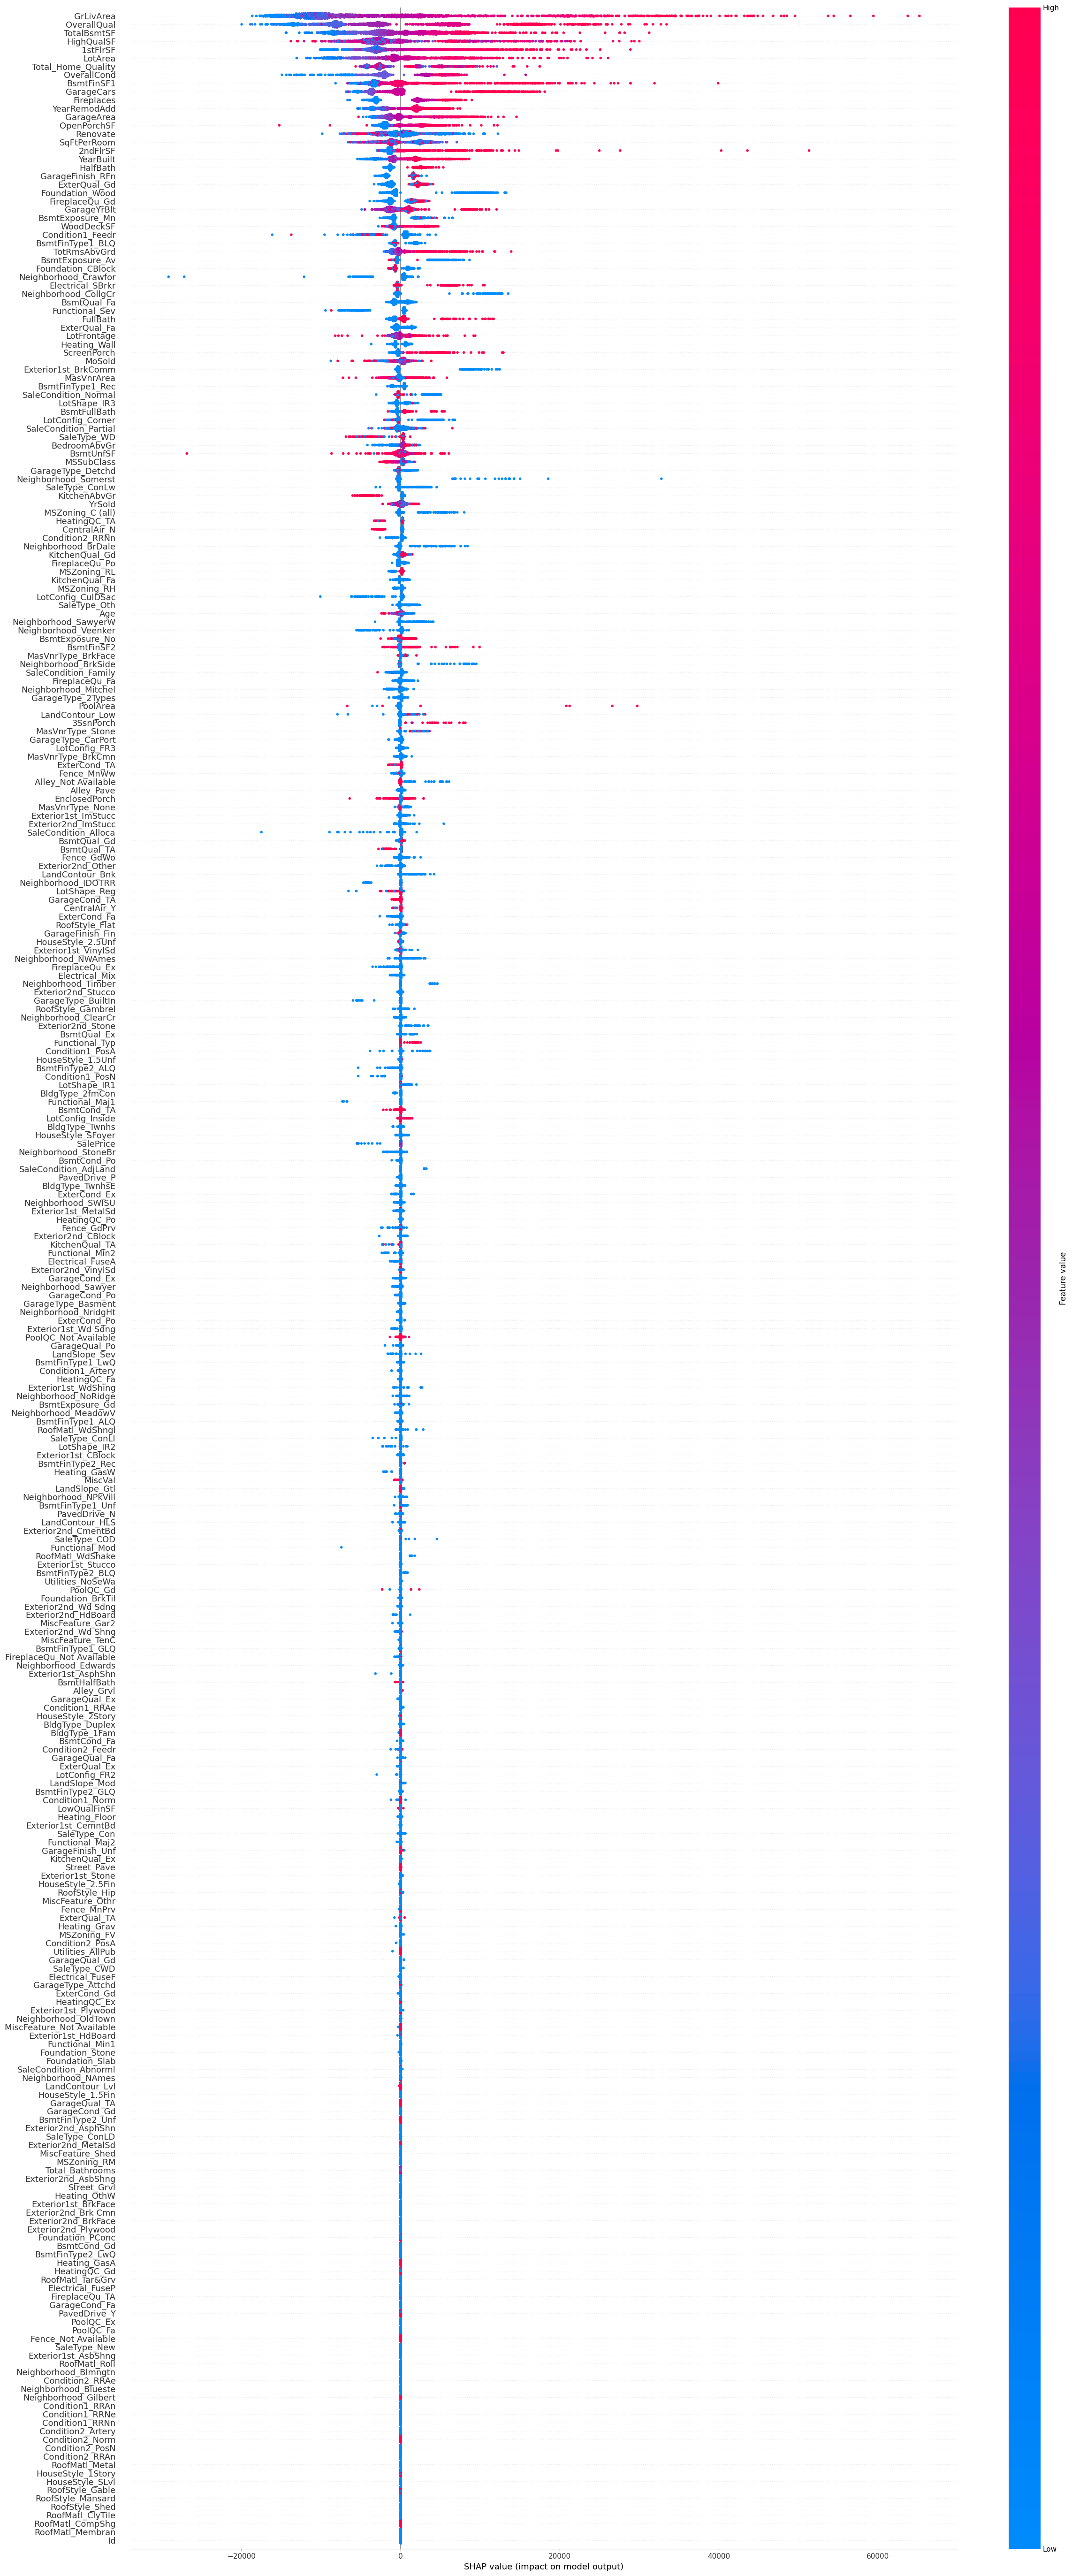

In [ ]:
shap_test = shap.TreeExplainer(catboost_model).shap_values(df_train)
shap.summary_plot(shap_test, df_train, auto_size_plot=True,plot_size=(25, 55), max_display=301)

Колонки датасета ниже заданного порога:

In [ ]:
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(df_train)

shap_abs_mean = np.abs(shap_values).mean(axis=0)

threshold = 5

unimportant_columns = (df_train.columns[shap_abs_mean < threshold].tolist())
unimportant_columns.remove('Id')

Удаление колонок ниже заданного порога из датасета:

In [ ]:
removed_df = df.drop(columns=unimportant_columns)

In [ ]:
removed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Columns: 212 entries, Id to Total_Home_Quality
dtypes: float16(147), float64(32), int64(10), uint8(23)
memory usage: 1.8 MB


In [ ]:
train = removed_df[removed_df['SalePrice'].notna()]
test = removed_df[removed_df['SalePrice'].isna()]
train['Id'] = 0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Обучение модели на датасете с исключенными колоноками:

In [ ]:
X_r = train.drop(columns = ['SalePrice'],axis = 1)
y_r = train['SalePrice']
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r,y_r, random_state = 42, test_size = 0.25)

In [ ]:
final_model = cb.CatBoostRegressor(**final_params)
final_model.fit(X_train_r, y_train_r)
final_pred = final_model.predict(X_test_r)
final_rmse = mean_squared_error(y_test_r, final_pred, squared=False)
final_rmlse = np.sqrt(np.mean(np.square(np.log1p(y_test_r) - np.log1p(final_pred))))


print('CatBoost RMSE on Test Data:', final_rmse)
print('CatBoost RMLSE on Test Data:', final_rmlse)

CatBoost RMSE on Test Data: 24305.320237354452
CatBoost RMLSE on Test Data: 0.12716241613484877


**Значение метрики увеличилось**

In [ ]:
catboost_model.save_model('house_price_model.cbm')

# Предсказание цен

In [ ]:
model_1 = cb.CatBoostRegressor()
model_1.load_model('house_price_model.cbm')

In [ ]:
df_test['SalePrice']= model_1.predict(df_test).round(0)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_test.sample(5)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SqFtPerRoom,Age,Renovate,HighQualSF,Total_Home_Quality,Total_Bathrooms
449,1910,5.08,3.22,7.39,6,1.95,1980,1980,0.00,0.00,...,0.00,0.00,1,0.00,1.70,29,0,254.12,7.95,1.35
250,1711,4.11,4.44,9.27,8,1.79,2006,2006,4.80,6.53,...,0.00,0.00,1,0.00,1.34,3,0,420.30,9.79,3.04
560,2021,3.04,4.11,8.76,5,1.79,1963,1963,0.00,6.19,...,0.00,0.00,0,0.00,1.94,45,0,154.91,6.79,1.00
7,1468,4.11,4.16,9.04,6,1.79,1998,1998,0.00,0.00,...,0.00,0.00,1,0.00,1.33,12,0,220.32,7.79,2.35
651,2112,3.93,4.23,8.86,5,1.79,1935,1950,0.00,5.17,...,0.00,0.00,1,0.00,1.61,73,15,144.36,6.79,2.00


In [ ]:
submission.sample(5)

,Id,SalePrice
152,1613,0
817,2278,0
748,2209,0
612,2073,0
1342,2803,0


In [ ]:
predicted_price_df = submission.merge(df_test[['Id', 'SalePrice']], on='Id', how='left').drop(columns = ['SalePrice_x'],axis = 1)
predicted_price_df.rename(columns={'SalePrice_y': 'SalePrice'}, inplace=True)
predicted_price_df.sample(5)

,Id,SalePrice
762,2223,282853.00
811,2272,198455.00
54,1515,186572.00
1356,2817,163690.00
135,1596,234036.00


In [ ]:
predicted_price_df.to_csv('/content/drive/My Drive/house_pred_price.csv', index=False)

# Заключение

В данном проекте на основе участия в соревновании Kaggle "House Prices - Advanced Regression Techniques" была поставлена цель предсказать стоимость жилых домов в городе Эймс штат Айова, используя продвинутые модели градиентного бустинга:

*   Catboost;
*   XGBoost;
*   LightGBM.

Для успешного прогнозирования цен на дома необходимо провести тщательную предобработку данных, включая заполнение пропущенных значений, кодирование категориальных признаков и масштабирование числовых характеристик. Важным шагом также является анализ и визуализация данных для понимания их распределения и взаимосвязей между признаками.

Для оценки качества модели используются различные метрики, такие как среднеквадратичная ошибка (RMSE) и среднеквадратичная логарифмическая ошибка (RMSLE). Эти метрики помогают оценить точность предсказаний и сравнить разные модели между собой.

Также важным аспектом является интерпретация результатов модели. Библиотека SHAP предоставляет возможность анализировать важность различных признаков в прогнозировании цен на дома. Это позволяет лучше понять, какие факторы оказывают наибольшее влияние на стоимость недвижимости.

Лучше всего себя показал Catboost + optuna. RMLSE составил 0.124. В конечном итоге, при помощи продвинутой модели градиентного бустинга удалось занять 907/4196 место и попасть в топ 22%.



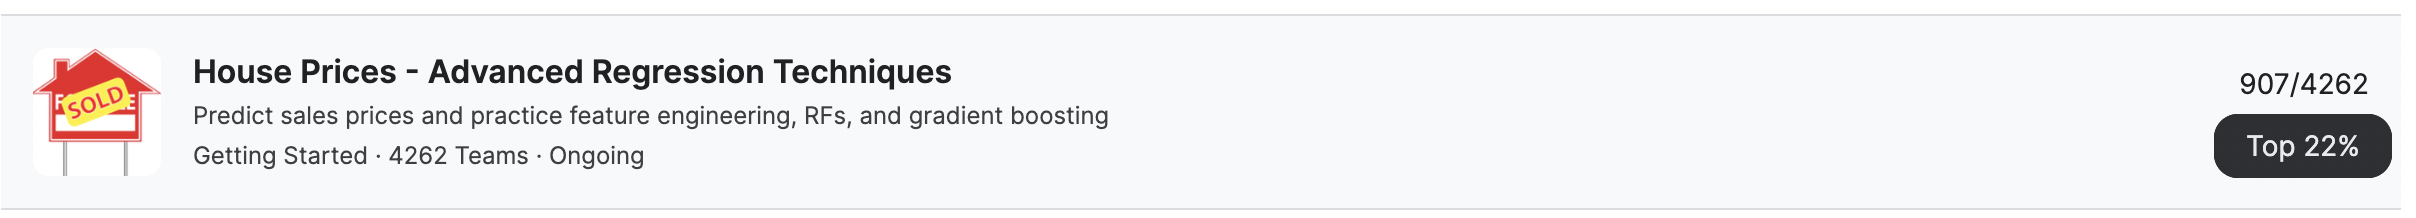